In [1]:
!git clone https://github.com/jan1na/Neural-Cellular-Automata.git

%cd Neural-Cellular-Automata

Cloning into 'Neural-Cellular-Automata'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 96 (delta 58), reused 45 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (96/96), 279.79 KiB | 1.44 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/Neural-Cellular-Automata


In [2]:
!pip install medmnist torch torchvision tqdm

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import PathMNIST
from train_utils import train, evaluate, plot_training_history
from models import NCA
import os

# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 698.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha2

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
val_dataset = PathMNIST(split='val', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 206M/206M [01:01<00:00, 3.36MB/s]


Epoch 01: Train Acc: 0.5839, Val Acc: 0.7136
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 02: Train Acc: 0.7600, Val Acc: 0.8330
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 03: Train Acc: 0.8377, Val Acc: 0.8423
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 04: Train Acc: 0.8751, Val Acc: 0.9085
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth
Converged (validation accuracy > 90%)
Training completed.


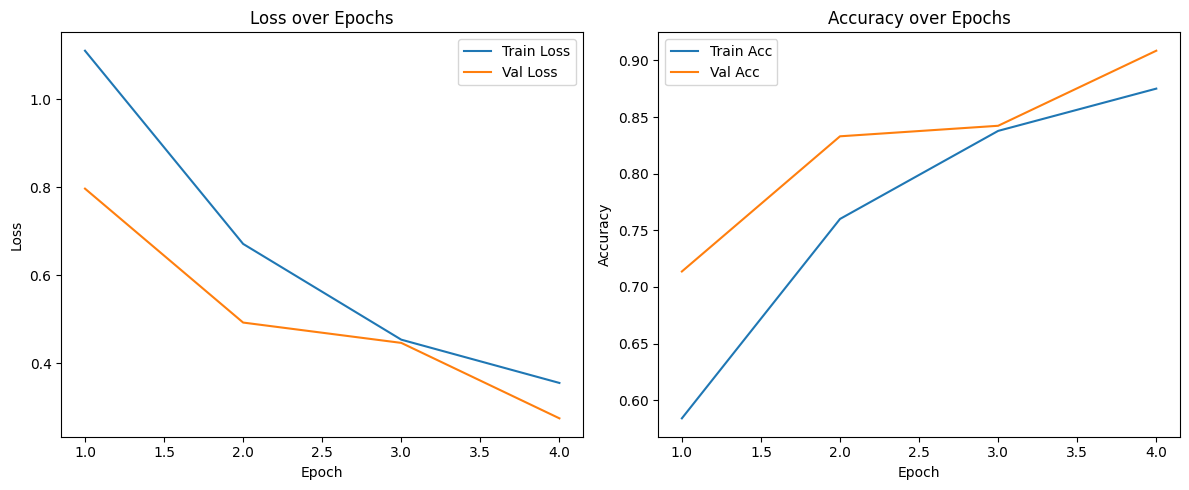

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NCA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 50

model_path = '/content/drive/MyDrive/NCA/best_nca_pathmnist.pth'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

plot_save_path = '/content/drive/MyDrive/NCA/plots/nca_training_history.png'
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_acc = 0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device, is_NCA=True)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, is_NCA=True)

    # Save for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:02d}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved to {model_path}")

    if val_acc > 0.90:
        print("Converged (validation accuracy > 90%)")
        break

print("Training completed.")
plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, plot_save_path)